To be able to run this file you must have PyTorch installed. Documentation for this can be found here: https://pytorch.org/get-started/locally/

# **Creating a PyTorch Linear Model Example**


## Import Dependencies

`import torch` -- Imports the PyTorch package

`from torch import nn` -- Contains all the basic building blocks for neural networks in PyTorch

`import matplotlib.pyplot as plt` -- Imports graph plotting functionality from Matplotlib the library

`torch.__version__` -- Used to check the version of PyTorch being used, helpful to see if PyTorch has been installed and correctly imported

In [232]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.1'

## Create a dataset with known parameters

Linear regression will be used to create data with **known parameters**, so that we can then build a model to try and learn these known parameters.

`torch.arange(start, end, step).unsqueeze(dim=1)`

Find `torch.arange` documentation here: https://pytorch.org/docs/stable/generated/torch.arange.html

This creates a 1 dimensional tensor with values starting at `start`, and ending at `end`, with the difference between each value being the `step`.

Find `unsqueeze(dim=1)` documentation here: https://pytorch.org/docs/stable/generated/torch.unsqueeze.html

This returns a new tensor with a dimension of size one inserted at the specified position, which in these scenario changes all of our values from being in one big tensor to each value being its own individual tensor.

In [233]:
# Known parameters
weight = 0.7
bias = 0.3

# Generate data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10] # Uncomment to see the first 10 samples

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now that we a dataset, we want to create a model that can learn the relationship between `X` (**features**) and `y` (**labels**).

## Creating training and tests sets from this dataset

`Training set` -- The model learns from this data set

`Testing set` -- The model is evaluated on this data to assess what it has learned

In [234]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# len(X_train), len(y_train), len(X_test), len(y_test) # Uncomment to see the lengths of the splits

### Visualise our data

Now that we have created our training and testing sets, we're going to create a function that will visualise the data.

In [235]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

Now lets use this function to visualise our training and testing datasets.

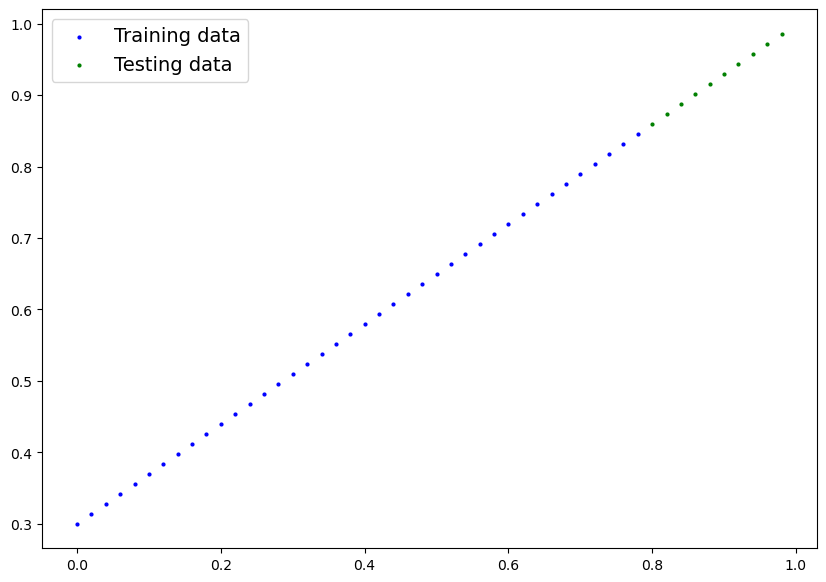

In [236]:
plot_predictions()

## Build a Linear Regression Model

Now that we have the data created and prepared, we need to create a model.

`nn.Module` -- documentation can be found here: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

It is a base class for all neural network modules, and our model must subclass this class.

`def __init__(self):` -- This is the constructor for the class, and is where we define what layers our model will contain

`nn.Linear` -- documentation can be found here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

This layer will apply a linear transformation to incoming data, and is initialised with random parameters

`def forward(self, x: torch.Tensor) -> torch.Tensor:` -- this constructs the forward computation of the model

`return self.linear_layer(x)` -- details how calculations in the model are performed, in this scenario input data `x` is passed through the linear layer where the linear transformation will be performed on it
    

In [237]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

After creating this model lets now print out its layout and parameters

In [238]:
torch.manual_seed(42) # Set random seed for reproducibility
model = LinearRegressionModel()

print("Model layout:")
print(model)
print("\nModel parameters:")
print(model.state_dict())

Model layout:
LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

Model parameters:
OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


### Create device agnostic code

This code will allow use to use a GPU if one is available, if not a CPU will be used for the training and testing of the model

In [239]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#device # Uncomment to see if the device is "cuda" or "cpu"

In [240]:
# Put the model on the available device
model = model.to(device)

## Training and Testing

Now that we have data and a model created, it is time to train our model. Currently with our randomly instantiated parameters the model is essentially randomly guessing.

By training the model these parameters will be finetuned, and hopefully replicate the parameters we defined earlier (`weight = 0.7` and `bias=0.3`).

### Loss function and Optimiser

Before we can start training we have to configure a `Loss function` and an `Optimiser`.

A `loss function` measures how wrong our model's predictions are compared the truth labels (e.g `y_test`).

For the training of our model we will use `L1Loss()`, which measures the MAE (mean absolute error) of our model's predictions.

Documentation for `L1Loss()` can be found here: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html

An `optimiser` is used to tell the model how to update its internal parameters to lower the loss.

For the training of this model we will use `optim.SGD`, an optimiser which implements Stochastic Gradient Descent. 

Documentation for `optim.SGD` can be found here: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

More information on Stochastic Gradient Descent can be found here: https://www.youtube.com/watch?v=IHZwWFHWa-w


In [241]:
# Create the loss function
loss_fn = nn.L1Loss() 

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating a training and testing loop

Now that we have defined a `Loss function` and an `Optimiser` it is time to train the model on the data created.

First all the data needs to be put on the same available device as the model, otherwise an error will occur if the data and the model are on different devices

In [242]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

First we will plot again the training and testing datasets, so that we have a point of comparison. We will then also use the untrained model to create predictions, and plot these predictions.

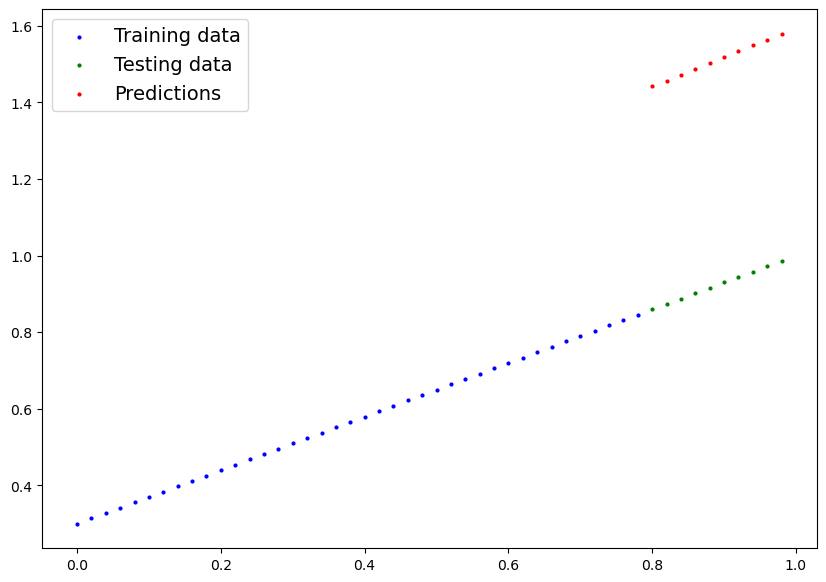

In [243]:
# Set seed for reproducibility
torch.manual_seed(42)

# Plot predictions with an untrained model
model.eval()
with torch.inference_mode():
    test_pred = model(X_test)

plot_predictions(predictions=test_pred.cpu())


We can see from this graph the the predictions made by the model are extremely bad. 

Now lets train the model for 100 epochs and plot the predictions it creates.

In [244]:
torch.manual_seed(42) # Set random seed for reproducibility

epochs = 100

for epoch in range(epochs):
    ### Training
    model.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089


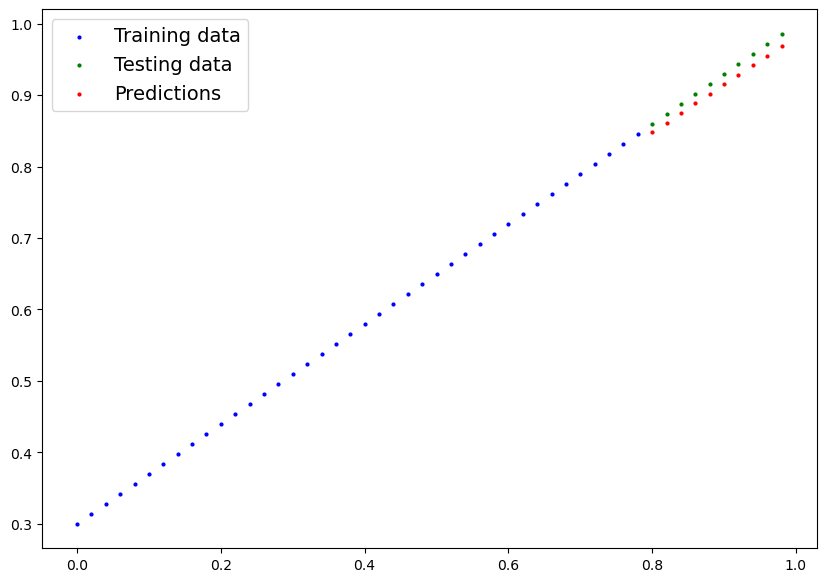

In [245]:
model.eval()
with torch.inference_mode():
    test_pred = model(X_test)

plot_predictions(predictions=test_pred.cpu())

Previously we saw that the randomly instantiated model parameters (`weight` and `bias`) were as follows:

Model parameters:
OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])

Let's compare these value to the adjusted values the model now contains after training

In [246]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])

By comparing these two we can see that by training the model we have brought these initially random values much closer to the hyper-parameters we instantiated when creating the data.

Let's now train the model for 1000 epochs, and see how close the model can fine tune its parameters.

In [247]:
torch.manual_seed(42) # Set random seed for reproducibility

epochs = 1000

for epoch in range(epochs):
    ### Training
    model.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 100 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


Now lets create predictions after training the model for 1000 epochs, and plot these predictions. We will also print out the model's parameters to see how close we have gotten to `weight=0.7` and `bias=0.3`

In [250]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

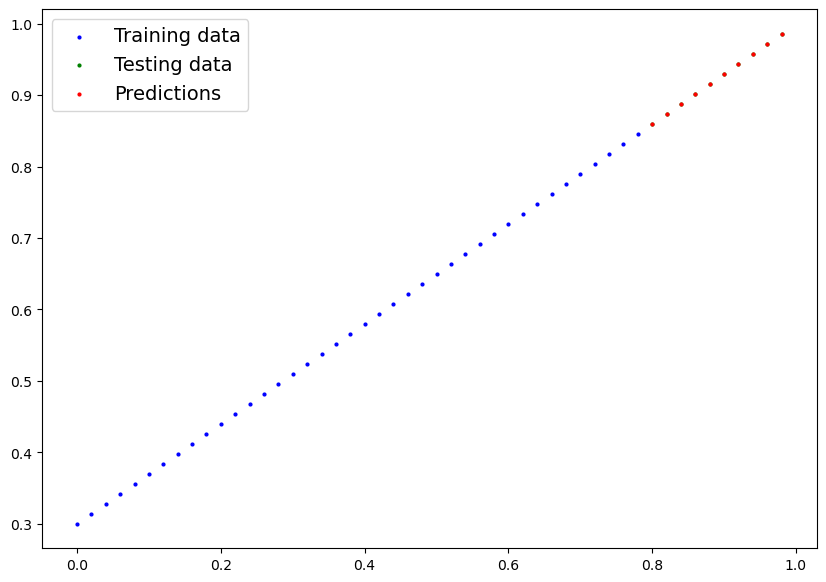

In [248]:
model.eval()
with torch.inference_mode():
    test_pred = model(X_test)

plot_predictions(predictions=test_pred.cpu())

From these graphs we can see how a machine learning model can be created to find patterns in data. Starting with randomly instantiated parameters, the model has been able to learn and fine tune these parameters to the point where they are extremely close to the hyper-parameters we instantiated for the creation of the data.

This code has been inspired and adapted from Daniel Bourke's PyTorch course, specifically section 01. PyTorch Workflow Fundamentals. This can be found here: https://www.learnpytorch.io/01_pytorch_workflow/
